# Agent Comparisons

Lets compare how Q-learning, SARSA and Monte Carlo agents performance goes in a simple grid world. We are mainly focused on the agents efficiency, in the sense of how much Return they will get while learning. In our grid world this essentially means quickly learning a good path, and avoid hitting the trap too much.

In general, having the agent interact with a real environment collecting data about states and rewards can be very expensive, either because it may be very slow, or because taking "bad" actions in certain states may have a high "business" cost. Having algorithms that don't need lots of expensive interactions in order to learn good policies is the usual "practical" goal of applications, and therefore minimizing the Return over the learning period is a reasonable goal.

In [1]:
import sys

sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import time

from grid_world.action import Action
from grid_world.grid_world import GridWorld
from grid_world.agents.monte_carlo_agent import MonteCarloAgent
from grid_world.agents.q_agent import QAgent
from grid_world.agents.sarsa_agent import SarsaAgent
from grid_world.visualization.format_objects import (
    get_policy_rec_str,
    get_policy_eval_str,
    get_world_str,
)
from grid_world.utils.returns import returns_from_reward
from grid_world.utils.policy import get_policy_rec, get_random_policy, sample_action

np.random.seed(13)

# World

Lets just look at the same simple world we analyzed in the agents notebooks.

In [2]:
gworld = GridWorld(
    grid_shape=(4, 5),
    terminal_states_coordinates=((0, 4),),
    walls_coordinates=((0, 1), (1, 1), (2, 3)),
    traps_coordinates=((1, 3),),
)
print(get_world_str(gworld))

3               

2          █    

1    █     ☠    

0 ⚐  █        ✘ 

  0  1  2  3  4 


In [3]:
def reward(e):
    if e == 1:
        return 0
    elif e == -1:
        return -100
    else:
        return -1


base_actions = [Action.up, Action.down, Action.left, Action.right]

# Training the agents

Alright lets run some training rounds.

In [4]:
training_rounds = 10
episodes = 200
q_returns = []

start = time.time()

for _ in range(training_rounds):
    q_agent = QAgent(
        world=gworld,
        reward_function=reward,
        actions=base_actions,
        gamma=1,
        alpha=0.3,
        epsilon=0.1,
    )

    q_episode_lengths, q_episode_returns = q_agent.train(episodes=episodes)
    q_returns.append(q_episode_returns)

end = time.time()
q_training_time = end - start

q_pi_r = get_policy_rec(q_agent.policy, gworld, q_agent.actions)
q_average_returns = np.mean(np.array(q_returns), axis=0)
q_std_returns = np.std(np.array(q_returns), axis=0)
print(get_policy_rec_str(q_pi_r, gworld))

 ↑  ↓  →  →  ↓ 

 →  →  ↓  █  ↓ 

 ↑  █  ↓  ☠  ↓ 

 ↑  █  →  →  ✘ 




In [5]:
sarsa_returns = []

start = time.time()

for _ in range(training_rounds):

    sarsa_agent = SarsaAgent(
        world=gworld,
        reward_function=reward,
        actions=base_actions,
        gamma=1,
        alpha=0.3,
        epsilon=0.1,
    )

    sarsa_episode_lengths, sarsa_episode_returns = sarsa_agent.train(episodes=episodes)
    sarsa_returns.append(sarsa_episode_returns)

end = time.time()
sarsa_training_time = end - start

sarsa_pi_r = get_policy_rec(sarsa_agent.policy, gworld, sarsa_agent.actions)
sarsa_average_returns = np.mean(np.array(sarsa_returns), axis=0)
sarsa_std_returns = np.std(np.array(sarsa_returns), axis=0)
print(get_policy_rec_str(sarsa_pi_r, gworld))

 ↑  →  ↓  →  ↑ 

 →  →  ↓  █  ← 

 ↑  █  ↓  ☠  ↓ 

 ↑  █  →  →  ✘ 




In [6]:
mc_returns = []

start = time.time()

for _ in range(training_rounds):

    mc_agent = MonteCarloAgent(
        world=gworld, reward_function=reward, actions=base_actions, gamma=1, epsilon=0.1
    )

    mc_episode_lengths, mc_episode_returns = mc_agent.train(episodes=episodes)
    mc_returns.append(mc_episode_returns)

end = time.time()
mc_training_time = end - start

mc_pi_r = get_policy_rec(mc_agent.policy, gworld, mc_agent.actions)
mc_average_returns = np.mean(np.array(mc_returns), axis=0)
mc_std_returns = np.std(np.array(mc_returns), axis=0)
print(get_policy_rec_str(mc_pi_r, gworld))

 ←  ↓  ↓  →  ↑ 

 ↑  →  ↓  █  ← 

 ↑  █  ↓  ☠  ↓ 

 ←  █  →  →  ✘ 




# Results

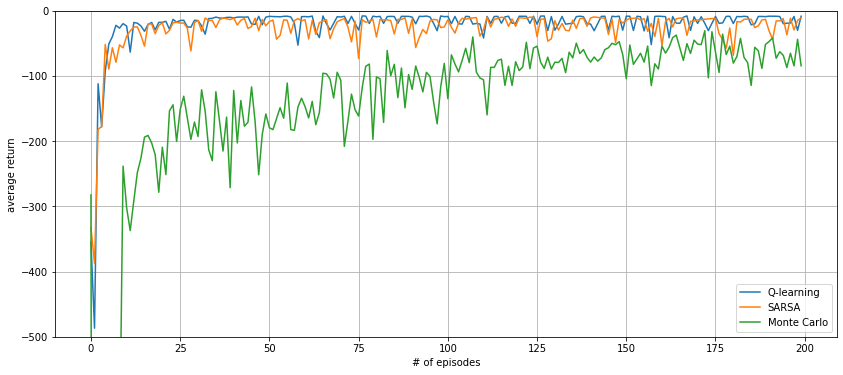

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(q_average_returns, label="Q-learning")
ax.plot(sarsa_average_returns, label="SARSA")
ax.plot(mc_average_returns, label="Monte Carlo")
ax.legend(loc="lower right")

ax.set(xlabel="# of episodes", ylabel="average return", ylim=[-500, 0])

ax.grid()

plt.show()

In [8]:
print(
    f"""
Average accumulated return

Q-learning: {np.sum(q_average_returns):.2f}
SARSA: {np.sum(sarsa_average_returns):.2f}
Monte Carlo: {np.sum(mc_average_returns):.2f}

Average accumulated return of last 100 episodes

Q-learning: {np.sum(q_average_returns[-100:]):.2f}
SARSA: {np.sum(sarsa_average_returns[-100:]):.2f}
Monte Carlo: {np.sum(mc_average_returns[-100:]):.2f}
"""
)


Average accumulated return

Q-learning: -4403.10
SARSA: -5637.50
Monte Carlo: -43580.50

Average accumulated return of last 100 episodes

Q-learning: -1562.10
SARSA: -2046.10
Monte Carlo: -7222.30



From the plot above it is clear Monte Carlo is not great at the problem at hand; although by the end it is getting to a performance close to the other agents, it takes a lot longer to learn the policy, and even after 200 episodes it is not all that great. From the example policies we printed, MC is clearly not optimal even at common states.

SARSA and Q-learning appear to have very similar performances, but Q-learning appears to be performing better on terms of accumulated returns; this is surprising as SARSA is suposed to have better online performance. This can be due to different factos, such as the number of episodes and the value of $\alpha$.

# Performance

The code we implemented has no focus at all on computational efficiency, so these results really shouldn't be taken very seriously; but it is very noticeble how slower Monte Carlo is then the other agents, for this reason and the fact that it is also not a very a good learner it is not really worth to keep analyzing it.

This could very well be due to implementation, as the code is entirely in python and focuses on readability. Our agents can be used to analyze "data" efficiency of the agents, but if one wants to check actual computational performance of these algorithms this code is not the way to go; however here is the performance I get



In [9]:
print(
    f"""
Q-learning average training time: {q_training_time/training_rounds:.2f}s
SARSA average training time: {sarsa_training_time/training_rounds:.2f}s
Monte Carlo average training time: {mc_training_time/training_rounds:.2f}s
"""
)


Q-learning average training time: 0.32s
SARSA average training time: 0.47s
Monte Carlo average training time: 20.52s



# Longer world

We can take a better look at the difference between SARSA and Q-learning by training then in a different setup, a longer world where the risk of taking the shorter path is much higher then taking the long one.

Even increasing the world just a little makes the problem much more difficult for the aggent, and they take much longer to get good policies as we will see.

In [10]:
new_world = GridWorld(
    grid_shape=(5, 5),
    terminal_states_coordinates=((1, 4),),
    walls_coordinates=((0, 1), (1, 1), (2, 3), (3, 3)),
    traps_coordinates=((1, 3),),
)
print(get_world_str(new_world))

4               

3          █    

2          █    

1    █     ☠  ✘ 

0 ⚐  █          

  0  1  2  3  4 


In [11]:
training_rounds = 20
long_sarsa_returns = []

for _ in range(training_rounds):

    long_sarsa_agent = SarsaAgent(
        world=new_world,
        reward_function=reward,
        actions=base_actions,
        gamma=1,
        alpha=0.03,
        epsilon=0.1,
    )

    long_sarsa_episode_lengths, long_sarsa_episode_returns = long_sarsa_agent.train(
        episodes=10000
    )
    long_sarsa_returns.append(long_sarsa_episode_returns)


long_sarsa_pi_r = get_policy_rec(
    long_sarsa_agent.policy, new_world, long_sarsa_agent.actions
)
long_sarsa_average_returns = np.mean(np.array(long_sarsa_returns), axis=0)
long_sarsa_std_returns = np.std(np.array(long_sarsa_returns), axis=0)
print(get_policy_rec_str(long_sarsa_pi_r, new_world))

 →  →  →  →  ↓ 

 →  ↑  ↑  █  ↓ 

 ↑  →  ↑  █  ↓ 

 ↑  █  ↓  ☠  ✘ 

 ↑  █  →  →  ↑ 




In [12]:
long_q_returns = []

for _ in range(training_rounds):

    long_q_agent = QAgent(
        world=new_world,
        reward_function=reward,
        actions=base_actions,
        gamma=1,
        alpha=0.03,
        epsilon=0.1,
    )

    long_q_episode_lengths, long_q_episode_returns = long_q_agent.train(episodes=10000)
    long_q_returns.append(long_q_episode_returns)


long_q_pi_r = get_policy_rec(long_q_agent.policy, new_world, long_q_agent.actions)
long_q_average_returns = np.mean(np.array(long_q_returns), axis=0)
long_q_std_returns = np.std(np.array(long_q_returns), axis=0)
print(get_policy_rec_str(long_q_pi_r, new_world))

 →  →  →  →  ↓ 

 ↓  ↑  ↓  █  ↓ 

 →  →  ↓  █  ↓ 

 ↑  █  ↓  ☠  ✘ 

 ↑  █  →  →  ↑ 




In [13]:
print(
    f"""
Accumulated return

Q-learning: {np.sum(long_q_episode_returns):.2f}
SARSA: {np.sum(long_sarsa_episode_returns):.2f}


Accumulated return of last 1000 episodes

Q-learning: {np.sum(long_q_episode_returns[-1000:]):.2f}
SARSA: {np.sum(long_sarsa_episode_returns[-1000:]):.2f}
"""
)


Accumulated return

Q-learning: -170455.00
SARSA: -141392.00


Accumulated return of last 1000 episodes

Q-learning: -16316.00
SARSA: -12237.00



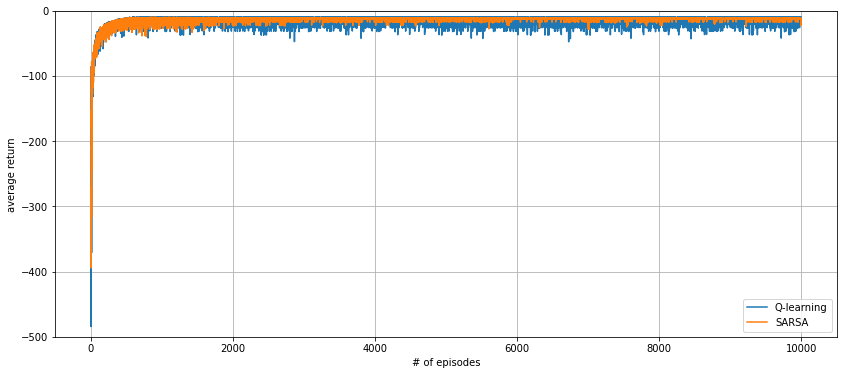

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(long_q_average_returns, label="Q-learning")
ax.plot(long_sarsa_average_returns, label="SARSA")
ax.legend(loc="lower right")

ax.set(xlabel="# of episodes", ylabel="average return", ylim=[-500, 0])

ax.grid()

plt.show()

Here the difference between the two agents is pretty clear, Q-learning prefers the "optimal" solution taking the shorter path, while SARSA takes the longer but saffer route. Since during training both agents follow an $\epsilon$-greedy policy Q-learning actually has a much worse "online" performance.

This behavior is simillar to the one on cliff walking example.